In [1]:
import heeps
from heeps.wavefront.get_array import show_wf
import heeps.util.img_processing as impro
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
diam_ext = 36.905                       # m
diam_nominal = 38.542                   # m
diam_nominal_METIS = 19.9               # mm
scaling = diam_nominal/diam_nominal_METIS
lt1_dist = 54*scaling                   # lith trap distance upstream of LS
lt1_diam = 33*scaling/diam_ext          # lith trap normalized diameter
lt2_dist = 198.7*scaling                # large lith trap distance upstream of LS
lt2_diam = 61*scaling/diam_ext          # large lith trap normalized diameter
print('lt1_dist = %.2f m'%lt1_dist)
print('lt1_diam = %.2f (times diam_ext)'%lt1_diam)
print('lt2_dist = %.2f m'%lt2_dist)
print('lt2_diam = %.2f (times diam_ext)'%lt2_diam)


lt1_dist = 104.59 m
lt1_diam = 1.73 (times diam_ext)
lt2_dist = 384.84 m
lt2_diam = 3.20 (times diam_ext)


In [3]:
conf = dict(
    mode = 'CVC',
    nframes = 1,#12000,
    hfov = 0.8,
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_lyot_stop = 'pupil/ls_L_RAVC_0.0291_0.0291_0.0317_285.fits',
    f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, verbose=True, **conf)
rim = psf_OFF.shape[-1] // 2 # image radius for raw contrast

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Load pupil from 'ELT_fullM1.fits'
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)
Create single off-axis PSF
   apply lyot stop from 'ls_L_RAVC_0.0291_0.0291_0.0317_285.fits'
   extract PSF on the detector: ndet=293


In [4]:
verbose = False
def PSF_at_lighttrap(**conf):
    # apply phase screen (scao residuals, ncpa, petal piston)
    wf = heeps.wavefront.add_errors(deepcopy(wf0), phase_screen=phase_screens[0], verbose=verbose, **conf)
    wf = heeps.optics.fp_mask(wf, verbose=verbose, **conf)
    show_wf(wf, 'amp', npupil=1024, savefits=True)
    wf = heeps.optics.lyot_stop(wf, verbose=verbose, **conf)
    return heeps.optics.detector(wf, verbose=verbose, **conf)
def raw_contrast(psfs):
    x = conf['pscale']*1e-3*np.arange(rim)
    plt.figure(figsize=(12,4))
    for psf_ON in psfs:
        y1 = impro.get_radial_profile(psf_OFF, (rim,rim), 1)[:-1]
        y2 = impro.get_radial_profile(psf_ON, (rim,rim), 1)[:-1]
        # normalize by the peak of the off-axis PSF
        peak = np.max(y1)
        y1 /= peak
        y2 /= peak
        # x axis in lam/D
        plt.plot(x,y2)
    plt.loglog()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.xlabel('Angular separation $[arcsec]$')
    plt.ylabel('raw contrast')
    plt.xlim(0.02, 0.75)
    plt.ylim(1e-8,1e-2)
    plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())



## No light trap

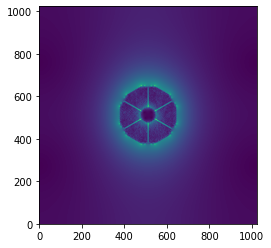

In [5]:
psf1 = PSF_at_lighttrap(**dict(conf, lt_diam=0, lt_dist=0))

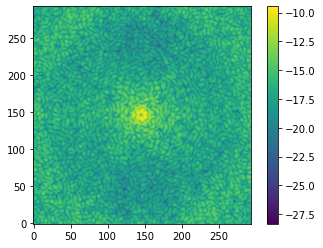

In [6]:
plt.imshow(np.log(psf1), origin='lower')
plt.colorbar();

## Small light trap

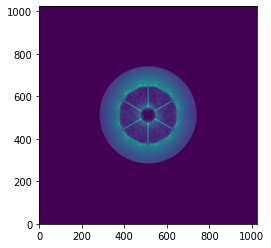

In [7]:
psf2 = PSF_at_lighttrap(**dict(conf, lt_diam=lt1_diam, lt_dist=lt1_dist))

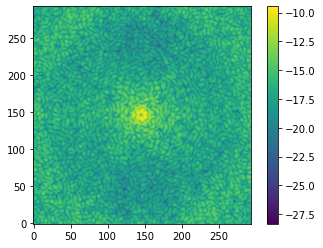

In [8]:
plt.imshow(np.log(psf2), origin='lower')
plt.colorbar();

## Large light trap

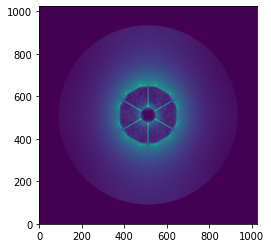

In [9]:
psf3 = PSF_at_lighttrap(**dict(conf, lt_diam=lt2_diam, lt_dist=lt2_dist))

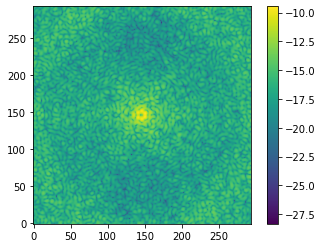

In [10]:
plt.imshow(np.log(psf3), origin='lower')
plt.colorbar();

## Raw contrast

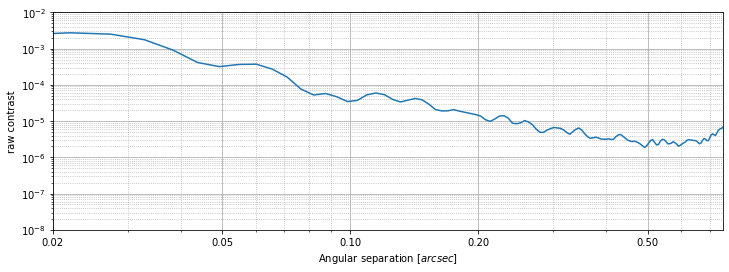

In [11]:
raw_contrast([psf1])

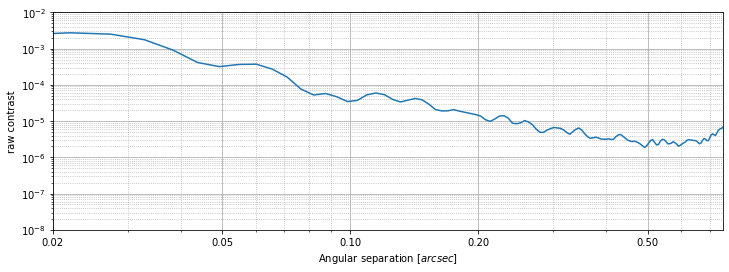

In [12]:
raw_contrast([psf2])

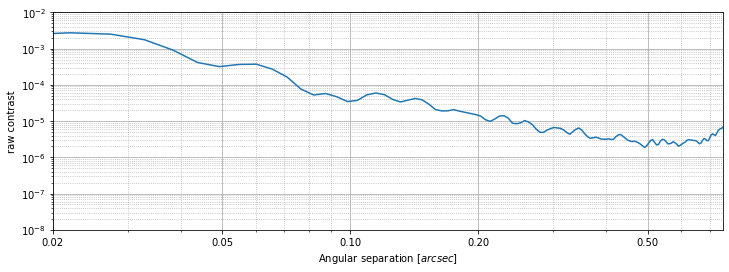

In [13]:
raw_contrast([psf3])

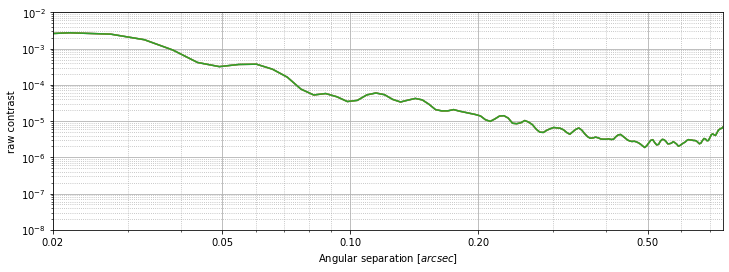

In [14]:
raw_contrast([psf1, psf2, psf3])